In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

In [4]:
partition_file = open("partitions_train.json", "rb")
partition = json.load(partition_file)
partition_file.close()

In [7]:
for k,v in partition.items():
    print(k, len(v))

train 4443
val 555
test 555


### import metadata

In [8]:
metadata = pd.read_csv("/home/chaehyeong/MARS_hj/Deliver_dataset/meta_information/metadata.csv")

In [9]:
metadata.head()

,IMDB_ID,Title,Genre,MPAA_rating,Actors,Poster_source,Director,Year
0,tt3462880,Wiener Dog Internationals,Family,G,"[{u'url': u'/name/nm0000392/', u'@type': u'Per...",https://m.media-amazon.com/images/M/MV5BMTcwMz...,"{u'url': u'/name/nm3406916/', u'@type': u'Pers...",2015
1,tt1028532,Hachi: A Dog's Tale,"Drama, Family",G,"[{u'url': u'/name/nm0000152/', u'@type': u'Per...",https://m.media-amazon.com/images/M/MV5BNzE4ND...,"{u'url': u'/name/nm0002120/', u'@type': u'Pers...",2009
2,tt1453405,Monsters University,"Animation, Adventure, Comedy, Family, Fantasy",G,"[{u'url': u'/name/nm0000345/', u'@type': u'Per...",https://m.media-amazon.com/images/M/MV5BMTUyOD...,"{u'url': u'/name/nm0768959/', u'@type': u'Pers...",2013
3,tt1910605,Rags,"Comedy, Drama, Family, Musical",G,"[{u'url': u'/name/nm1551130/', u'@type': u'Per...",https://m.media-amazon.com/images/M/MV5BYTI1OT...,"{u'url': u'/name/nm0937306/', u'@type': u'Pers...",2012
4,tt0206588,Beethoven's 3rd,"Family, Comedy",G,"[{u'url': u'/name/nm0001662/', u'@type': u'Per...",https://m.media-amazon.com/images/M/MV5BYTU2Yz...,"{u'url': u'/name/nm0262693/', u'@type': u'Pers...",2000


In [10]:
new_label = []
imdb_id = []
tokenized_script = []
mpaa_rating_to_low_med_high = {"G" : "LOW", "PG" : "LOW", "PG-13" : "MED" , "R" : "HIGH", "NC-17" : "HIGH"}


In [11]:
from transformers import AutoTokenizer
tokenzier =  AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
for idx, row in tqdm(metadata.iterrows()):
    new_label.append(mpaa_rating_to_low_med_high[row["MPAA_rating"]])
    imdb_id.append(row["IMDB_ID"])
    script = ""
    with open(f"/home/chaehyeong/MARS_hj/Deliver_dataset/Script/{row['IMDB_ID']}.txt", "r") as f:
        for line in f:
            script += line

    script = script.lower()
    cur_tokenized_script = tokenzier(script, max_length=512, truncation=True, padding='max_length')
    
    tokenized_script.append(cur_tokenized_script)

5562it [03:32, 26.14it/s]


In [15]:
import matplotlib.pyplot as plt

## check label distribution

(array([ 162.,    0., 3193.,    0.,    0., 1559.,    0.,  639.,    0.,
           9.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

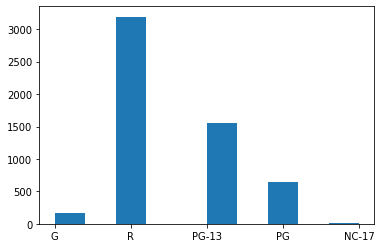

In [17]:
plt.hist(metadata["MPAA_rating"])

(array([ 801.,    0.,    0.,    0.,    0., 3202.,    0.,    0.,    0.,
        1559.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

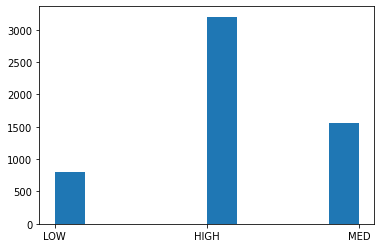

In [16]:
plt.hist(new_label)

In [20]:
label_to_idx = {"LOW" : 0, "MED" : 1, "HIGH" : 2}

In [22]:
preprocessed_data_df = pd.DataFrame({"IMDB_id": imdb_id, "tokenized_script":[t["input_ids"] for t in tokenized_script], "rating": [label_to_idx[l] for l in new_label]})

In [23]:
preprocessed_data_df.head()

,IMDB_id,tokenized_script,rating
0,tt3462880,"[101, 1031, 2879, 1033, 2748, 999, 5256, 2039,...",0
1,tt1028532,"[101, 2061, 1010, 2130, 2065, 8912, 2288, 2439...",0
2,tt1453405,"[101, 1001, 1996, 3300, 5923, 1005, 1055, 4198...",0
3,tt1910605,"[101, 2047, 2259, 2103, 1012, 1012, 2025, 1037...",0
4,tt0206588,"[101, 2054, 2024, 2017, 2725, 1029, 3611, 2056...",0


In [24]:
preprocessed_data_df.to_csv("preprocessed_data.csv")

## make partition for train, validation, test

In [28]:
import random

shuffled_id = list(preprocessed_data_df["IMDB_id"])
random.shuffle(shuffled_id)

In [30]:
print(shuffled_id[:10])

['tt0120157', 'tt2125608', 'tt1634121', 'tt0238546', 'tt1600196', 'tt1192628', 'tt0821810', 'tt1519664', 'tt1024943', 'tt0279111']


In [31]:
train_id = shuffled_id[:int(len(shuffled_id)*0.8)]
val_id = shuffled_id[int(len(shuffled_id)*0.8):int(len(shuffled_id)*0.9)]
test_id = shuffled_id[int(len(shuffled_id)*0.9):]

In [32]:
print(len(train_id))
print(len(val_id))
print(len(test_id))

4449
556
557


In [35]:
partition = {
    "train" : train_id,
    "val" : val_id,
    "test" : test_id

}

In [36]:
with open("partition.json" , "w") as f:
    json.dump(partition, f)

### test if dataloader works

In [1]:
from dataloader import get_dataloader

In [2]:
test_dataloader = get_dataloader("test", 3)

In [3]:
test_batch = next(iter(test_dataloader))

2024    [101, 2013, 1023, 1024, 2322, 2000, 2340, 1024...
Name: tokenized_script, dtype: object
5175    [101, 1031, 20696, 2015, 1033, 7632, 1012, 104...
Name: tokenized_script, dtype: object
90    [101, 2045, 2001, 2498, 2569, 2055, 9198, 2221...
Name: tokenized_script, dtype: object


In [5]:
test_batch["y"]

tensor([[2],
        [0],
        [0]])

In [6]:
import pandas as pd

In [7]:
data = pd.read_csv("preprocessed_data.csv")

In [8]:
labels = data["rating"]

In [13]:
low_count = len(labels[labels==0])
med_count = len(labels[labels==1])
high_count = len(labels[labels==2])

In [14]:
print(low_count)
print(med_count)
print(high_count)

801
1559
3202


In [15]:
import torch

In [17]:
weights = torch.Tensor([low_count, med_count, high_count])
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)


tensor([0.1440, 0.2803, 0.5757])
tensor([0.5669, 0.2913, 0.1418])
